# LangChain: Agents

## Outline:

* Using built in LangChain tools: DuckDuckGo search and Wikipedia
* Defining your own tools

In [1]:
import os

# Read API key from text file
with open(r"D:\desktop\Pankaj_New_OpenAI_Key.txt", "r") as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

import warnings
warnings.filterwarnings("ignore")

Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [ ]:
'''# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"
    '''

## Built-in LangChain tools

In [ ]:
#!pip install -U wikipedia

In [ ]:
import langchain
print(langchain.__version__)


# Step 1: Import libraries

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, List,Annotated
import operator
from langchain_core.messages import BaseMessage


# Step2: Create LLM

In [5]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Step 3: Create tool llm_math

In [7]:
@tool
def llm_math(question: str) -> str:
    """Solve math problems"""
    return llm.invoke(f"Solve this math problem: {question}").content


# Step 3: Create tool wiki_search

In [9]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia"""
    return llm.invoke(f"Give a short Wikipedia-style summary of {query}")


# Step 5: Create tool list

In [11]:
tools = [wiki_search,llm_math]

In [13]:
type(tools)

list

In [15]:
llm_with_tools = llm.bind_tools(tools)

# Step 6: Create Agent as class

In [17]:
import inspect
print(inspect.getsource(TypedDict))

def TypedDict(typename, fields=None, /, *, total=True, **kwargs):
    """A simple typed namespace. At runtime it is equivalent to a plain dict.

    TypedDict creates a dictionary type such that a type checker will expect all
    instances to have a certain set of keys, where each key is
    associated with a value of a consistent type. This expectation
    is not checked at runtime.

    Usage::

        >>> class Point2D(TypedDict):
        ...     x: int
        ...     y: int
        ...     label: str
        ...
        >>> a: Point2D = {'x': 1, 'y': 2, 'label': 'good'}  # OK
        >>> b: Point2D = {'z': 3, 'label': 'bad'}           # Fails type check
        >>> Point2D(x=1, y=2, label='first') == dict(x=1, y=2, label='first')
        True

    The type info can be accessed via the Point2D.__annotations__ dict, and
    the Point2D.__required_keys__ and Point2D.__optional_keys__ frozensets.
    TypedDict supports an additional equivalent form::

        Point2D = TypedDict('Poi

In [19]:
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]


### This is the heart of how LangGraph works
### It defines the state structure that flows through your LangGraph.
### Think of it as a schema (blueprint) for memory that each node in the graph receives and returns.
### TypedDict : defines the shape of state : “My agent’s state is a dictionary with fixed keys.
### list[BaseMessage] → what kind of data is stored.BaseMessage is LangChain’s chat message object, not a string.
### Examples:HumanMessage(content="Sort the list"),AIMessage(content="Here is the result"),ToolMessage(content="[['Jen','Ayai'], ...]")
### Annotated[..., operator.add] → how state is merged: It tells LangGraph:“When multiple nodes update messages, merge them using +.”
### Means: new_messages = old_messages + incoming_messages
### Without Annotated each node would overwrite messages.
### Think of this line as saying:“My agent memory is a growing chat history, and whenever new messages appear, append them.”Think of this line as saying:“My agent memory is a growing chat history, and whenever new messages appear, append them.”


In [22]:
from langchain_core.messages import ToolMessage

In [26]:
from langchain_core.messages import AIMessage

def agent_node(state: AgentState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}   # ONLY the new AIMessage

In [28]:
from langchain_core.messages import ToolMessage

def tool_node(state: AgentState):
    last_message = state["messages"][-1]
    tool_messages = []

    tool_map = {t.name: t for t in tools}

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]

        result = tool_map[tool_name].invoke(tool_args)

        tool_messages.append(
            ToolMessage(
                content=result,
                tool_call_id=tool_call["id"]
            )
        )

    return {"messages": tool_messages}

In [30]:
from langchain_core.messages import AIMessage

def should_use_tool(state: AgentState) -> bool:
    last = state["messages"][-1]
    return isinstance(last, AIMessage) and bool(last.tool_calls)

### this function is the core logic of your LangGraph agent.
### State = container
### messages = one variable inside that container
### So state looks like:{"messages": ["some user input", "some previous output"]}
### This function represents one node in your LangGraph.
### user_message = state["messages"][-1]
### The -1 means:the most recent message
### Think of messages like a chat history:[ old message, older message, latest message ]
### response = llm.invoke(user_message): send the user’s latest message to the LLM
### response.content: The LLM returns an object (not just text).Inside it, the text answer is in
### return {"messages": state["messages"] + [response.content]}: create a new state dictionary and return it
### So you are:
### Keeping history
### Appending the new response
### Passing updated state forward
### This is how memory/state grows in LangGraph.

## Whole function in simple words :This function does:

- 1️⃣ Take the last user message
- 2️⃣ Send it to the LLM
- 3️⃣ Get the LLM’s reply
- 4️⃣ Add the reply to the message list
- 5️⃣ Return the updated state

In [32]:
graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)

graph.add_node("tool", tool_node)

graph.add_conditional_edges(
    "agent",
    should_use_tool,
    {True: "tool", False: END}
)

graph.add_edge("tool", "agent")
graph.set_entry_point("agent")

app = graph.compile()


### graph = StateGraph(AgentState): create a graph object that will pass around a state of type AgentState
### So this line says:“My graph will work with a state dictionary that has a messages list.”
### Graph will carry → {"messages": [...]}
### graph.add_node("agent", agent_node): Create a node called agent that runs the function agent_node(state)
### agent node = LLM logic
### graph.set_entry_point("agent"): define where the graph starts.“When I call this graph, start execution from the agent node.”
### Without this, LangGraph wouldn’t know which node to run first.
### So now flow is: START → agent
### graph.add_edge("agent", END): define what happens after the agent node finishes.“After running agent, go to END (stop execution).
### So the full flow becomes:agent  →  END
### app = graph.compile(): convert your graph definition into a runnable application.
### Before this:
### graph is just a blueprint (like a design)
### After this: app is executable
### graph is:
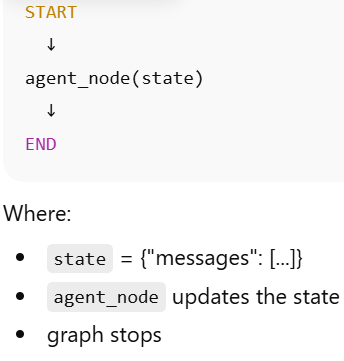END


In [34]:
from langchain_core.messages import HumanMessage

In [36]:
app.invoke({
    "messages": [HumanMessage(content="What is 6 * 7?")]
})

{'messages': [HumanMessage(content='What is 6 * 7?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 69, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68HLiYt4vddSz3bVInQk6GjICmNC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3154-abde-7302-8d19-9d9450549b2b-0', tool_calls=[{'name': 'llm_math', 'args': {'question': '6 * 7'}, 'id': 'call_tOKvRKBSAavEfxoE6UcL52Nc', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 69, 'output_tokens': 18, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'c

In [38]:
app.invoke({"messages": [HumanMessage(content = "What is the 25 percent of 300?")]})

{'messages': [HumanMessage(content='What is the 25 percent of 300?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 71, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68HWFfzm6B4GKmeZ7KteIh7qNzMk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3154-d981-78f0-9ac5-f3fde1e624ca-0', tool_calls=[{'name': 'llm_math', 'args': {'question': 'What is 25% of 300?'}, 'id': 'call_2qdzspJBVhLbxIiRG8HZ7Q9r', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 71, 'output_tokens': 23, 'total_tokens': 94, 'input_t

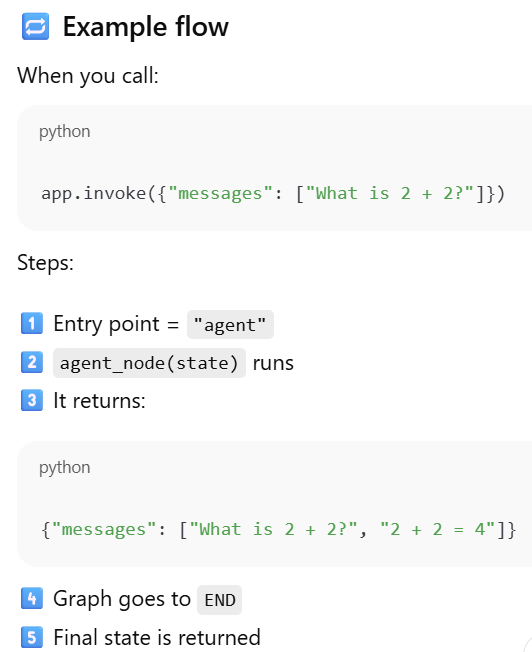

## Wikipedia example

In [40]:
question = "Tom M. Mitchell is an American computer scientist \
and the Founders University Professor at Carnegie Mellon University (CMU)\
what book did he write?"
 

In [42]:
result = app.invoke({"messages": [HumanMessage(content = question)]})
result

{'messages': [HumanMessage(content='Tom M. Mitchell is an American computer scientist and the Founders University Professor at Carnegie Mellon University (CMU)what book did he write?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 90, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68HzjOrAQvZcoI14FLIs91vpEAUm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3155-4bf1-7783-bb4a-3794c8037c4a-0', tool_calls=[{'name': 'wiki_search', 'args': {'query': 'Tom M. Mitchell'}, 'id': 'call_AM13Z1IBSUHQUfMAyxveNz1K', 'type': 'tool_call

## Python Agent

In [44]:
@tool
def python_repl(code: str) -> str:
    """Execute python code and return the result."""
    try:
        local_vars = {}
        exec(code, {}, local_vars)
        return str(local_vars.get("result", local_vars))
    except Exception as e:
        return str(e)


# local_vars.get("result", local_vars) :  This line is a fallback mechanism.
# If the executed code explicitly set a variable called result, return that Otherwise, return whatever variables were created.
# Return the answer if the agent named it result; otherwise return everything it produced.


In [46]:
tools = tools + [python_repl]
tools

[StructuredTool(name='wiki_search', description='Search Wikipedia', args_schema=<class 'langchain_core.utils.pydantic.wiki_search'>, func=<function wiki_search at 0x000001AEF91CE160>),
 StructuredTool(name='llm_math', description='Solve math problems', args_schema=<class 'langchain_core.utils.pydantic.llm_math'>, func=<function llm_math at 0x000001AEF91CF740>),
 StructuredTool(name='python_repl', description='Execute python code and return the result.', args_schema=<class 'langchain_core.utils.pydantic.python_repl'>, func=<function python_repl at 0x000001AEF91944A0>)]

In [48]:
llm_with_tools = llm.bind_tools(tools)

In [50]:
customer_list = [["Harrison", "Chase"], 
                 ["Lang", "Chain"],
                 ["Dolly", "Too"],
                 ["Elle", "Elem"], 
                 ["Geoff","Fusion"], 
                 ["Trance","Former"],
                 ["Jen","Ayai"]
                ]

In [52]:
question = f"""
Write Python code ONLY.
Store the final output in a variable named result.
Data: {customer_list}
Task: Sort customers alphabetically by last name.
"""
result = app.invoke({"messages": [HumanMessage(content = question)]})
result

{'messages': [HumanMessage(content="\nWrite Python code ONLY.\nStore the final output in a variable named result.\nData: [['Harrison', 'Chase'], ['Lang', 'Chain'], ['Dolly', 'Too'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Jen', 'Ayai']]\nTask: Sort customers alphabetically by last name.\n", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 164, 'total_tokens': 264, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68J7CB1tw22h03wu4Cp75A2fhGTa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3156-5c5a-7300-a8eb-ff278fc93057-0',

#### View detailed outputs of the chains

In [54]:
import langchain
langchain.debug=True
question = f"""
You MUST use the python_repl tool.
Do NOT answer in natural language.
Write Python code ONLY.
Store the final output in a variable named result.

Data: {customer_list}
Task: Sort customers alphabetically by last name.
"""


result = app.invoke({"messages": [HumanMessage(content = question)]})
result


{'messages': [HumanMessage(content="\nYou MUST use the python_repl tool.\nDo NOT answer in natural language.\nWrite Python code ONLY.\nStore the final output in a variable named result.\n\nData: [['Harrison', 'Chase'], ['Lang', 'Chain'], ['Dolly', 'Too'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Jen', 'Ayai']]\nTask: Sort customers alphabetically by last name.\n", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 180, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68JKeHX8D0LzF7OPoUrSqtoXJj13', 'service_tier': 'default', 'finish_reason': 'tool_calls'

In [56]:
langchain.debug=False

In [58]:
for step in app.stream({"messages": [f"""Sort these customers by \
last name and then first name \
and print the output: {customer_list}"""]}) :
    print("STEP:", step)


STEP: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 151, 'total_tokens': 274, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68JUKqTTgyBpiVyZE0pmdsruTiLI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3156-b7db-7b53-ae03-d80cf104bb9b-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "customers = [['Harrison', 'Chase'], ['Lang', 'Chain'], ['Dolly', 'Too'], ['Elle', 'Elem'], ['Geoff', 'Fusion'], ['Trance', 'Former'], ['Jen', 'Ayai']]"}, 'id': 'call_3xv09QObTWEsNybsq6bVrDmg', 'type': 'tool_call'}, {'name': 'python_repl', 'args': {'code': 'sorted_customers = s

In [59]:
sales = [
    ["Alice", "Laptop", 1200],
    ["Bob", "Phone", 800],
    ["Alice", "Phone", 800],
    ["Bob", "Laptop", 1200],
    ["Alice", "Tablet", 600],
    ["Bob", "Tablet", 600],
    ["Charlie", "Phone", 800],
    ["Charlie", "Laptop", 1200]
]


In [62]:
question = f"""
Write Python code only.
Using the following sales data: {sales}

1. Compute total sales per person.
2. Sort by total sales in descending order.
3. Store final output in variable called result.
"""

result = app.invoke({"messages": [HumanMessage(content = question)]})
result

{'messages': [HumanMessage(content="\nWrite Python code only.\nUsing the following sales data: [['Alice', 'Laptop', 1200], ['Bob', 'Phone', 800], ['Alice', 'Phone', 800], ['Bob', 'Laptop', 1200], ['Alice', 'Tablet', 600], ['Bob', 'Tablet', 600], ['Charlie', 'Phone', 800], ['Charlie', 'Laptop', 1200]]\n\n1. Compute total sales per person.\n2. Sort by total sales in descending order.\n3. Store final output in variable called result.\n", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 203, 'prompt_tokens': 205, 'total_tokens': 408, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68JjehaFLpH7t4nFr0KoQDwb9M72', 'serv

In [64]:
students = [
    ["Alice", "Math", 85],
    ["Bob", "Math", 78],
    ["Alice", "Science", 92],
    ["Bob", "Science", 88],
    ["Charlie", "Math", 90],
    ["Charlie", "Science", 95],
    ["Alice", "English", 75],
    ["Bob", "English", 80],
    ["Charlie", "English", 85]
]


In [66]:
question = f"""
Write Python code only to solve the following problem.

Using this data: {students}

1. Compute average marks per student.
2. Sort by average marks in descending order.
3. Store the final answer in a variable called result.
"""

In [68]:
result = app.invoke({"messages": [HumanMessage(content = question)]})
result

{'messages': [HumanMessage(content="\nWrite Python code only to solve the following problem.\n\nUsing this data: [['Alice', 'Math', 85], ['Bob', 'Math', 78], ['Alice', 'Science', 92], ['Bob', 'Science', 88], ['Charlie', 'Math', 90], ['Charlie', 'Science', 95], ['Alice', 'English', 75], ['Bob', 'English', 80], ['Charlie', 'English', 85]]\n\n1. Compute average marks per student.\n2. Sort by average marks in descending order.\n3. Store the final answer in a variable called result.\n", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 240, 'prompt_tokens': 211, 'total_tokens': 451, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id':

In [70]:
question = "Find the top 3 longest words in this sentence: Artificial intelligence is transforming data science rapidly"

result = app.invoke({"messages": [HumanMessage(content = question)]})
result

{'messages': [HumanMessage(content='Find the top 3 longest words in this sentence: Artificial intelligence is transforming data science rapidly', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 103, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68KEu35i3aGX5GeDSOpr43DigsV8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3157-69a8-7bf3-8b2c-a8e3bddbe560-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "sentence = 'Artificial intelligence is transforming data science rapidly'\nwords = sentence.split()\nlongest_words 

In [72]:
for step in app.stream({"messages": ["Find the top 3 longest words in this sentence: Artificial intelligence is transforming data science rapidly"]}):
    print("STEP:", step)


STEP: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 103, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68KTZ2RpWdZaODM1IE3Fm2Cy97J0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3157-a753-7180-9242-c864c4da1865-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "sentence = 'Artificial intelligence is transforming data science rapidly'\nwords = sentence.split()\nlongest_words = sorted(words, key=len, reverse=True)[:3]\nlongest_words"}, 'id': 'call_w0Gvj8cYkVjNyxIawNYMBLWZ', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'

| Goal              | Method                     |
| ----------------- | -------------------------- |
| See state flow    | `app.stream()`             |
| See prompt & code | `print()` inside node      |
| See tool calls    | `python_repl.invoke` print |
| See internals     | `langchain.debug=True`     |
| Understand logic  | step-by-step logging       |


## Define your own tool

In [ ]:
#!pip install DateTime

In [74]:
from datetime import datetime

In [76]:
@tool
def time(text: str) -> str:
    """Returns todays date, use this for any \
    questions related to knowing todays date. \
    The input should always be an empty string, \
    and this function will always return todays \
    date - any date mathmatics should occur \
    outside this function."""
    return str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [78]:
tools = tools + [time]
tools

[StructuredTool(name='wiki_search', description='Search Wikipedia', args_schema=<class 'langchain_core.utils.pydantic.wiki_search'>, func=<function wiki_search at 0x000001AEF91CE160>),
 StructuredTool(name='llm_math', description='Solve math problems', args_schema=<class 'langchain_core.utils.pydantic.llm_math'>, func=<function llm_math at 0x000001AEF91CF740>),
 StructuredTool(name='python_repl', description='Execute python code and return the result.', args_schema=<class 'langchain_core.utils.pydantic.python_repl'>, func=<function python_repl at 0x000001AEF91944A0>),
 StructuredTool(name='time', description='Returns todays date, use this for any     questions related to knowing todays date.     The input should always be an empty string,     and this function will always return todays     date - any date mathmatics should occur     outside this function.', args_schema=<class 'langchain_core.utils.pydantic.time'>, func=<function time at 0x000001AE958B7C40>)]

In [80]:
llm_with_tools = llm.bind_tools(tools)

In [82]:
question = "whats the date and time now?"


In [84]:
result = app.invoke({"messages": [question]})
result

{'messages': ['whats the date and time now?',
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 159, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D68MT1p0ST0TaGIt9msTN30uKc1Wg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3159-8993-7c71-8217-35b35232fa08-0', tool_calls=[{'name': 'time', 'args': {'text': ''}, 'id': 'call_6VpU3zW2Mwlbmt5YNyierg04', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 159, 'output_tokens': 12, 'total_tokens': 171, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoni